In [66]:
from typing import List
from copy import deepcopy

import collections
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import BitArray
from qiskit_aer import AerSimulator  # For MPS Simulator.
from qiskit.primitives import StatevectorEstimator

import ffsim

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from functools import partial, reduce

import numpy as np

# from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch
from qiskit_addon_sqd.qubit import solve_qubit, sort_and_remove_duplicates

from adaptvqe.pools import DVG_CEO, FullPauliPool, TiledPauliPool
from adaptvqe.convert import cirq_pauli_sum_to_qiskit_pauli_op
from adaptvqe.hamiltonians import XXZHamiltonian
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt, TensorNetAdapt

In [67]:
ibm_computer: str = "ibm_fez"

service = qiskit_ibm_runtime.QiskitRuntimeService(channel="local")
computer = service.backend()
sampler = Sampler(computer)

## Build a tiled pool

In [68]:
max_mpo_bond = 100
dmrg_mps_bond = 10
adapt_mps_bond = 10
l = 4

j_xy = 1
j_z = 1
h = XXZHamiltonian(j_xy, j_z, l, diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond)
dmrg_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")
pool = FullPauliPool(n=l, max_mpo_bond=max_mpo_bond)

# Run 200 iterations of ADAPT-VQE for small problem instance, selecting randomly among degenerate gradients.
# Form a list of all unique operators ever selected for this small instance.
ixs = []
for _ in range(10):
    my_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    my_adapt.run()
    data = my_adapt.data
    for i in data.result.ansatz.indices:
        if i not in ixs:
            ixs.append(i)

print(f"Pool will be tiled from {len(ixs)} ops")
source_ops = [pool.operators[index].operator for index in ixs]

Got DMRG energy -6.46410e+00

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(4.000000000000005)]
Operator(s) added to ansatz: [228]
Initial energy: -3.0000000000000044
Optimizing energy with indices [228]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499795
(change of -1.2360679774997907)
Current ansatz: [228]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696158
Operators under consideration (1):
[26]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000003)]
Operator(s) added to ansatz: [26]
Initial energy: -4.236067977499795
Optimizing energy with indices [228, 26]...
Starting point: [np.float64(-0.5535743588970451), np.float64(0.0

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526201775818
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.485071048468282)]
Operator(s) added to ansatz: [198]
Initial energy: -6.1231056255624825
Optimizing energy with indices [228, 26, 228, 198]...
Starting point: [np.float64(-0.7853947065772612), np.float64(0.7853985308794263), np.float64(0.12248927961669973), np.float64(0.0)]

Current energy: -6.32727615476475
(change of -0.2041705292022673)
Current ansatz: [228, 26, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962581220582
Operators under consideration (1):
[45]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.089492926690258)]
Operator(s) added to ansatz: [45]
Initial energy: -6.32727615476475
Optimizing energy with indices [228, 26, 228, 198, 45]...
Starting point: [np.float64(-0.7853947065771537), np.float64(0.7853982468607333), np.float64(0

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0000000000000018)]
Operator(s) added to ansatz: [225]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 225]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617651
(change of -0.12310562561764193)
Current ansatz: [244, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199444833
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.485071047430588)]
Operator(s) added to ansatz: [210]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 210]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248927934376257), np.float64(0.0)]

Current energy: -6.327276154819709
(change of -0.20417052920205858)
Current ansatz: [244, 79, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580530028
Operators under consideration (1):
[57]
Corresponding gradients (ordered by magnitude):
[np.float64(2.089492926737888)]
Operator(s) added to

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002093)
Current ansatz: [241, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132733
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0000000000000044)]
Operator(s) added to ansatz: [210]
Initial energy: -6.000000000000005
Optimizing energy with indices [241, 79, 210]...
Starting point: [np.float64(-0.785398171825775), np.float64(0.7853981815917083), np.float64(0.0)]

Current energy: -6.12310562561764
(change of -0.12310562561763483)
Current ansatz: [241, 79, 210]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199634684
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(2.4850710475364073)]
Operator(s) added to ansatz: [225]
Initial energy: -6.1231056256176

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002093)
Current ansatz: [241, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132733
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0)]
Operator(s) added to ansatz: [228]
Initial energy: -6.000000000000005
Optimizing energy with indices [241, 79, 228]...
Starting point: [np.float64(-0.785398171825775), np.float64(0.7853981815917083), np.float64(0.0)]

Current energy: -6.123105625617642
(change of -0.1231056256176366)
Current ansatz: [241, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199441697
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.485071047428846)]
Operator(s) added to ansatz: [210]
Initial energy: -6.123105625617642
Optimizing e

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819982
(change of -0.20417052920234013)
Current ansatz: [241, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096404138082
Operators under consideration (1):
[108]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0894916438682456)]
Operator(s) added to ansatz: [108]
Initial energy: -6.327276154819982
Optimizing energy with indices [241, 79, 228, 210, 108]...
Starting point: [np.float64(-0.7853982024976439), np.float64(0.7853981311150512), np.float64(0.1635702864850446), np.float64(0.16356997194303877), np.float64(0.0)]

Current energy: -6.46410161460898
(change of -0.13682545978899796)
Current ansatz: [241, 79, 228, 210, 108]
Performing final convergence check...
Total gradient norm: 0.00032540987752766417

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138082 > 1e-05)

Init

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999417229
(change of -1.3737154597822618)
Current ansatz: [211, 244, 79]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958970181085
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(1.9999999998057472)]
Operator(s) added to ansatz: [225]
Initial energy: -5.999999999417229
Optimizing energy with indices [211, 244, 79, 225]...
Starting point: [np.float64(-9.855379305101342e-06), np.float64(0.7853981714334987), np.float64(0.7853981407341446), np.float64(0.0)]

Current energy: -6.123105625047579
(change of -0.12310562563034999)
Current ansatz: [211, 244, 79, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752620051138
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850710482521707)]
Operator(s) adde

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 19.595917942265466
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000005)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operators under consideration (1):
[79]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000007)]
Operator(s) added to ansatz: [79]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 79]...
Starting point: [np.float64(0.5535743588970456), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0000000000000018)]
Operator(s) added to ansatz: [225]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 225]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617651
(change of -0.12310562561764193)
Current ansatz: [244, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199444833
Operators under consideration (1):
[147]
Corresponding gradients (ordered by magnitude):
[np.float64(2.485071047430588)]
Operator(s) added to ansatz: [147]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 147]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248927934376257), np.float64(0.0)]

Current energy: -6.327276154820074
(change of -0.20417052920242362)
Current ansatz: [244, 79, 225, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240963655680355
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0894919825745366)]
Operator(s) added 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002066)
Current ansatz: [244, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897113273
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.000000000000004)]
Operator(s) added to ansatz: [198]
Initial energy: -6.000000000000005
Optimizing energy with indices [244, 74, 198]...
Starting point: [np.float64(0.7853981703433218), np.float64(-0.7853981783720295), np.float64(0.0)]

Current energy: -6.123105625617648
(change of -0.12310562561764282)
Current ansatz: [244, 74, 198]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200186185
Operators under consideration (1):
[177]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850710478437783)]
Operator(s) added to ansatz: [177]
Initial energy: -6.1231056256176

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199444833
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.485071047430588)]
Operator(s) added to ansatz: [210]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 210]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248927934376257), np.float64(0.0)]

Current energy: -6.327276154819709
(change of -0.20417052920205858)
Current ansatz: [244, 79, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580530028
Operators under consideration (1):
[147]
Corresponding gradients (ordered by magnitude):
[np.float64(2.089492926737891)]
Operator(s) added to ansatz: [147]
Initial energy: -6.327276154819709
Optimizing energy with indices [244, 79, 225, 210, 147]...
Starting point: [np.float64(0.7853981700346647), np.float64(0.7853981900506334), np.float6

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998188
(change of -1.763932022498393)
Current ansatz: [228, 31]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897114057
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(1.9999999999944205)]
Operator(s) added to ansatz: [225]
Initial energy: -5.999999999998188
Optimizing energy with indices [228, 31, 225]...
Starting point: [np.float64(-0.7853985607314264), np.float64(-0.7853989420959467), np.float64(0.0)]

Current energy: -6.12310562561064
(change of -0.12310562561245231)
Current ansatz: [228, 31, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917522148955662
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.485068789868906)]
Operator(s) added to ansatz: [198]
Initial energy: -6.12310562561064


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441738
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850710474288693)]
Operator(s) added to ansatz: [210]
Initial energy: -6.123105625617638
Optimizing energy with indices [241, 26, 228, 210]...
Starting point: [np.float64(-0.7853981634447681), np.float64(0.7853981634524064), np.float64(0.12248927934332132), np.float64(0.0)]

Current energy: -6.327276154819988
(change of -0.2041705292023499)
Current ansatz: [241, 26, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096404138126
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.089491643867201)]
Operator(s) added to ansatz: [198]
Initial energy: -6.327276154819988
Optimizing energy with indices [241, 26, 228, 210, 198]...
Starting point: [np.float64(-0.7853981604483139), np.float64(0.7853981623217249), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615071929
(change of -0.13682546025194053)
Current ansatz: [241, 26, 228, 210, 198]
Performing final convergence check...
Total gradient norm: 0.00013555110317705658

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138126 > 1e-05)
Pool will be tiled from 19 ops


## Run ADAPT at larger size to get a sequence of circuits.

In [69]:
def neel_circuit(nq, start_zero=True):
    circuit = QuantumCircuit(nq)
    for i in range(nq):
        if (i % 2 == 0 and start_zero) or (i % 2 != 0 and not start_zero):
            circuit.x(i)
        else:
            circuit.id(i)
    return circuit

In [70]:
# Now go to the larger size.
new_l = 2 * l
j_xy = 1
j_z = 1
h = XXZHamiltonian(
    j_xy, j_z, new_l,
    store_ref_vector=False,
    diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond
)
dmrg_energy = h.ground_energy
exact_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")

h_of = h.operator
h_cirq = of.transforms.qubit_operator_to_pauli_sum(h_of)
h_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(h_cirq)

tiled_pool = TiledPauliPool(n=new_l, source_ops=source_ops)
num_ops = len(tiled_pool.operators)
print(f"Tiled pool has {num_ops} operators.")

tn_adapt = TensorNetAdapt(
    pool=tiled_pool,
    custom_hamiltonian=h,
    verbose=True,
    threshold=10**-5,
    max_adapt_iter=30,
    max_opt_iter=10000,
    sel_criterion="gradient",
    recycle_hessian=False,
    rand_degenerate=True,
    max_mpo_bond=max_mpo_bond,
    max_mps_bond=adapt_mps_bond
)
tn_adapt.initialize()
nq = tn_adapt.n

circuits = []
adapt_energies = []
for i in range(3):
    print(f"On iteration {i}.")
    tn_adapt.run_iteration()
    data = tn_adapt.data
    ansatz_circuit = pool.get_circuit(tn_adapt.indices, tn_adapt.coefficients)
    print("coefficients:", tn_adapt.coefficients)
    print("indices:", tn_adapt.indices)
    # Prepare the HF reference state, then add the Ansatz circuit.
    q = QuantumRegister(nq)
    circuit = QuantumCircuit(q)
    ref_circuit = neel_circuit(nq, start_zero=False)
    circuit = circuit.compose(ref_circuit)
    circuit = circuit.compose(ansatz_circuit)
    circuit.measure_all()
    circuits.append(circuit)
    adapt_energies.append(tn_adapt.energy)

Got DMRG energy -1.34997e+01
Tiled pool has 80 operators.

tensor-net-adapt prepared with the following settings:
> Pool: tiled_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  30
> candidates per iteration:  1

Initial energy: -6.999999999999975
On iteration 0.

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 3.99999999999997
Operator 1: 3.999999999999984
Operator 2: 3.9999999999999902
Operator 3: 3.999999999999996
Operator 4: 3.9999999999999947
Operator 5: -3.9999999999999862
Operator 6: 3.999999999999985
Operator 7: -3.99999999999997
Operator 8: 3.999999999999984
Operator 9: -3.9999999999999902
Operator 10: 3.999999999999985
Operator 11: 3.99

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


In [71]:
for circuit in circuits:
    print(circuit.depth())

9
18
23


Text(0, 0.5, 'Energy error')

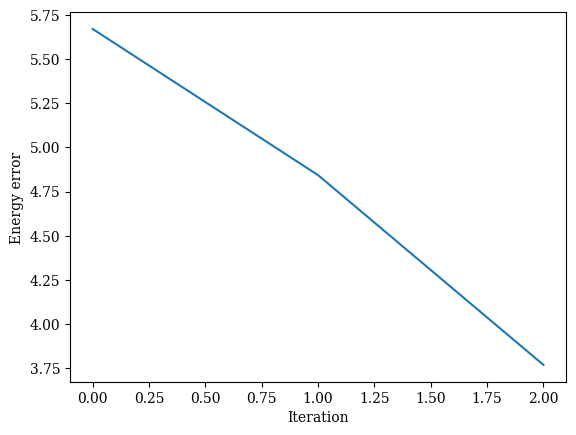

In [72]:
fig, ax = plt.subplots()
ax.plot(abs(np.array(adapt_energies) - exact_energy))
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Carry out SQD.

In [73]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

spin_a_layout = list(range(0, 12))
spin_b_layout = [12, 13, 14, 15, 19, 35, 34, 33, 32, 31, 30, 29]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=computer, initial_layout=initial_layout[:nq]
)


In [74]:
bit_arrays = []
counts_list = []
for circuit in circuits:
    pass_manager.pre_init = ffsim.qiskit.PRE_INIT
    to_run = pass_manager.run(circuit)
    print(f"Gate counts (w/ pre-init passes): {to_run.count_ops()}")
    job = sampler.run([to_run], shots=30_000)
    bit_array = job.result()[0].data.meas
    counts1 = bit_array.get_counts()
    counts_list.append(counts1)
    bit_arrays.append(deepcopy(bit_array))

Gate counts (w/ pre-init passes): OrderedDict({'rz': 9, 'measure': 8, 'cx': 6, 'sx': 4, 'x': 3, 'barrier': 2})
Gate counts (w/ pre-init passes): OrderedDict({'rz': 20, 'cx': 12, 'sx': 10, 'measure': 8, 'x': 3, 'barrier': 3})
Gate counts (w/ pre-init passes): OrderedDict({'rz': 33, 'cx': 20, 'sx': 18, 'measure': 8, 'barrier': 4, 'x': 3})


In [75]:
energies = []
errors = []

for bit_array in bit_arrays:
    print(bit_array.num_bits)
    bit_matrix = bit_array.to_bool_array()
    print(bit_matrix.shape)
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    energies.append(min_energy)
    errors.append(err)

8
(30000, 8)
8
(30000, 8)
8
(30000, 8)


Text(0, 0.5, 'Energy error')

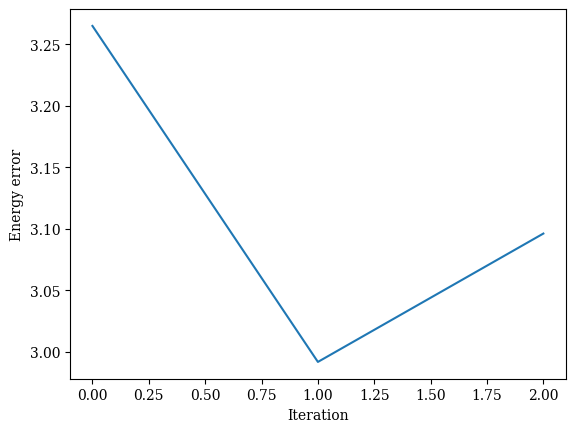

In [76]:
fig, ax = plt.subplots()
ax.plot(errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Concatenate mulitple rounds

In [77]:
stacked_energies = []
stacked_errors = []

for i in range(1, len(counts_list) + 1):
    all_counts = collections.Counter()
    tuple_of_counts = tuple(counts_list[:i])
    assert len(tuple_of_counts) == i
    for counts in tuple_of_counts:
        for bitstring, count in counts.items():
            all_counts[bitstring] += count

    bit_array = qiskit.primitives.BitArray.from_counts(all_counts)
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    stacked_energies.append(min_energy)
    stacked_errors.append(err)


Text(0, 0.5, 'Energy error')

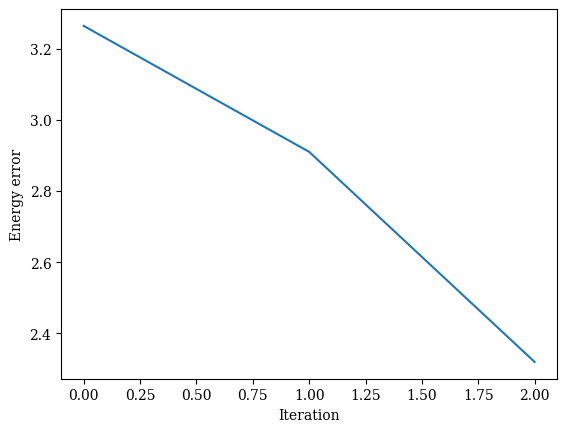

In [78]:
fig, ax = plt.subplots()
ax.plot(stacked_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

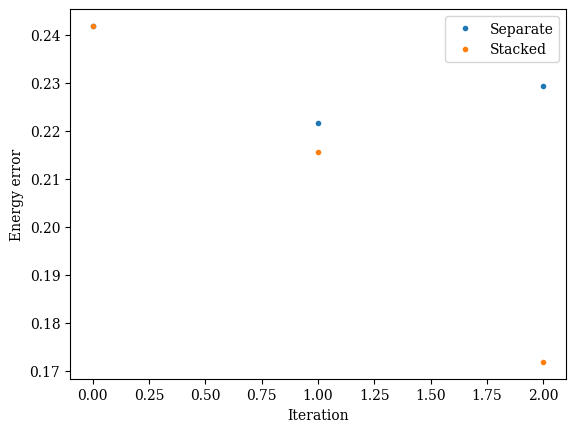

In [82]:
rel_errors = np.array(errors) / abs(exact_energy)
stacked_rel_errors = np.array(stacked_errors) / abs(exact_energy)

fig, ax = plt.subplots()
ax.plot(rel_errors, '.', label="Separate")
ax.plot(stacked_rel_errors, '.', label="Stacked")
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")
ax.legend()